In [ ]:
# Note: all numbers in Table 1 both in main text and in supplementary are taken from section Table 1 + Figure 1. Only for VKDNW_sigle, VKDNW_agg we have taken numbers from section '# Ablation: add components' as this is newer run where layers were taken from beginning, not the end of the network

# Toy example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import ndcg_score
from scipy.stats import kendalltau, spearmanr

damaged_top = [80, 70, 100, 90, 60, 50, 40, 30, 20, 10]
perfect_top = [100, 90, 80, 70, 60, 50, 10, 20, 30, 40]
colors_damaged= ['#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#394B39', '#394B39', '#394B39', '#394B39', '#394B39', '#394B39']
colors_perfect = ['#394B39', '#394B39', '#394B39', '#394B39', '#394B39', '#394B39', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F']

In [2]:
kendalltau(list(range(len(damaged_top))), perfect_top), spearmanr(list(range(len(damaged_top))), perfect_top)

(SignificanceResult(statistic=-0.7333333333333333, pvalue=0.002212852733686067),
 SignificanceResult(statistic=-0.8787878787878788, pvalue=0.0008138621117322101))

In [3]:
kendalltau([10, 9, 8, 7, 6, 5, 4, 3, 2, 1], damaged_top), spearmanr([10, 9, 8, 7, 6, 5, 4, 3, 2, 1], damaged_top)

(SignificanceResult(statistic=0.8222222222222221, pvalue=0.0003576940035273369),
 SignificanceResult(statistic=0.9030303030303028, pvalue=0.00034361219776328223))

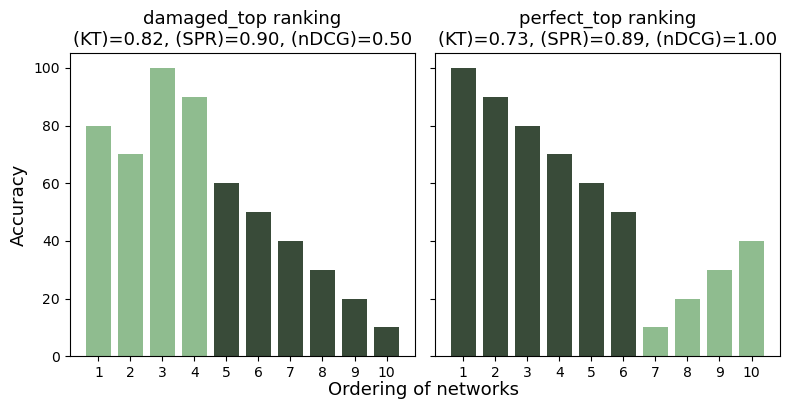

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axs[0].bar(range(1, 11), damaged_top, color=colors_damaged)
axs[0].set_xticks(range(1,11))
axs[0].set_title('damaged_top ranking\n(KT)=0.82, (SPR)=0.90, (nDCG)=0.50', fontsize=13)
axs[1].bar(range(1, 11), perfect_top, color=colors_perfect)
axs[1].set_xticks(range(1,11))
axs[1].set_title('perfect_top ranking\n(KT)=0.73, (SPR)=0.89, (nDCG)=1.00', fontsize=13)
axs[0].set_ylabel('Accuracy', fontsize=13)
fig.text(0.535, 0, 'Ordering of networks', ha='center', fontsize=13)
plt.tight_layout()
plt.savefig('example.eps', format='eps')
plt.show()

In [210]:
table = None
top1, top2, top3 = int(top/2), top, top*2
for rank in ['random_rank', 'perfect_rank', 'damaged_rank']:
    eval = {
        'ranking': [rank],
        'kendalltau': [kendalltau(data['val_acc'], data[rank]).statistic],
        'kendalltau_pvalue': [kendalltau(data['val_acc'], data[rank]).pvalue],
        f'ndcg_top{top1}': [ndcg_score(data['val_acc'].values.reshape(1, -1), data[rank].values.reshape(1, -1), k=top1)],
        f'ndcg_top{top2}': [ndcg_score(data['val_acc'].values.reshape(1, -1), data[rank].values.reshape(1, -1), k=top2)],
        f'ndcg_top{top3}': [ndcg_score(data['val_acc'].values.reshape(1, -1), data[rank].values.reshape(1, -1), k=top3)],
    }
    if table is None:
        table = pd.DataFrame(eval)
    else:
        table = pd.concat([table, pd.DataFrame(eval)], ignore_index=True)
table

,ranking,kendalltau,kendalltau_pvalue,ndcg_top50,ndcg_top100,ndcg_top200
0,random_rank,-0.003712,0.57775,0.145351,0.150057,0.183933
1,perfect_rank,1.000000,0.00000,1.000000,1.000000,1.000000
2,damaged_rank,0.960396,0.00000,0.670379,0.718864,0.770708


In [207]:
table = table.T

In [208]:
table = table.style.format(decimal=',', thousands='.', precision=2)

print(table.to_latex())

\begin{tabular}{llll}
 & 0 & 1 & 2 \\
ranking & random_rank & perfect_rank & damaged_rank \\
kendalltau & -0,00 & 1,00 & 0,96 \\
kendalltau_pvalue & 0,58 & 0,00 & 0,00 \\
ndcg_top50 & 0,15 & 1,00 & 0,67 \\
ndcg_top100 & 0,15 & 1,00 & 0,72 \\
ndcg_top200 & 0,18 & 1,00 & 0,77 \\
\end{tabular}



# VKDNW and trainable_params correlation

/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


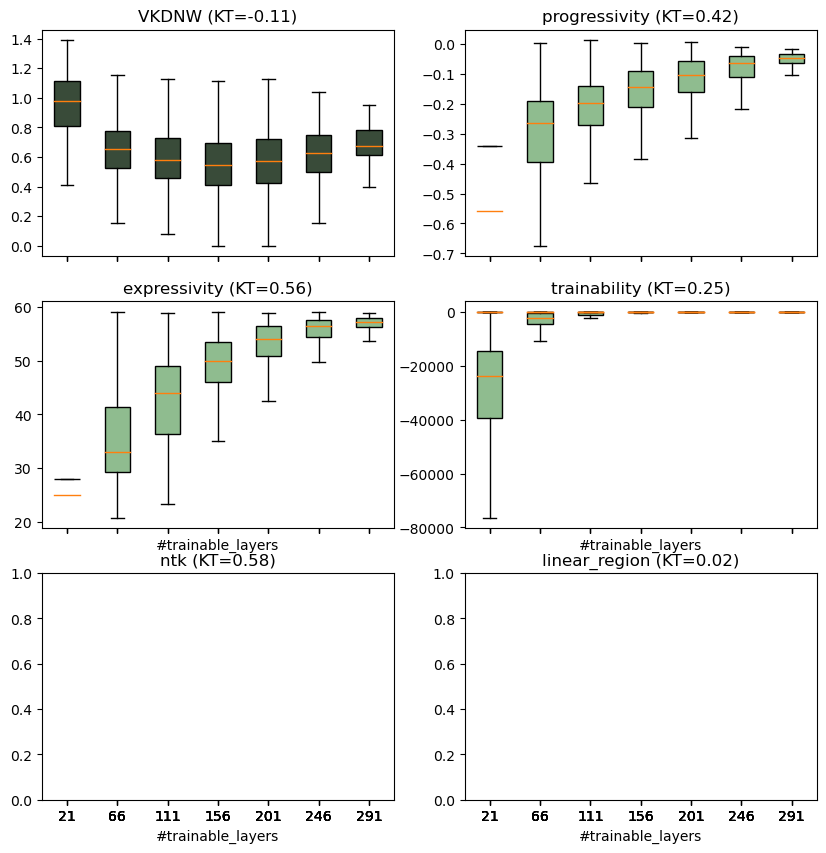

In [2]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
api_wandb = wandb.Api()
run = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/ss2kwvpp').scan_history())
from scipy.stats import kendalltau
from nats_bench import create
from tss_utils import generate_accs
import os
dataset = 'ImageNet16-120'
compute_graf = True

api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

if os.path.exists(f"./tss_features_{dataset}.pickle"):
    archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
else:
    archs = generate_accs(api_nats, dataset=dataset)
    print(f'No. of generated archs: {archs.shape[0]}')
    archs.to_pickle(f"./tss_features_{dataset}.pickle")


run.rename({'arch': 'net_str'}, axis=1, inplace=True)
run = pd.merge(archs, run, on='net_str', how='inner')
if compute_graf:
    run = run.loc[run['net'].notnull(), :]

run['trainability'] = run['trainability'].astype(float)
run['progressivity'] = run['progressivity'].astype(float)
run['expressivity'] = run['expressivity'].astype(float)
run['vkdnw_entropy'] = run['vkdnw_entropy'].astype(float)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharex=True)

pred = 'vkdnw_entropy'
data_to_plot = [run[pred][run['vkdnw_dim'] == cat] for cat in run['vkdnw_dim'].unique()]
kt = kendalltau(run['vkdnw_dim'], run[pred]).statistic
bplot = axs[0, 0].boxplot(data_to_plot, labels=run['vkdnw_dim'].unique(), showfliers=False, patch_artist=True)
for patch, color in zip(bplot['boxes'], ['#394B39', '#394B39', '#394B39', '#394B39', '#394B39', '#394B39', '#394B39']):
    patch.set_facecolor(color)
axs[0, 0].set_title(f"VKDNW (KT={kt:.2f})")

pred = 'progressivity' 
data_to_plot = [run[pred][run['vkdnw_dim'] == cat] for cat in run['vkdnw_dim'].unique()]
kt = kendalltau(run['vkdnw_dim'], run[pred]).statistic
bplot = axs[0, 1].boxplot(data_to_plot, labels=run['vkdnw_dim'].unique(), showfliers=False, patch_artist=True)
for patch, color in zip(bplot['boxes'], ['#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F']):
    patch.set_facecolor(color)
axs[0, 1].set_title(f"{pred} (KT={kt:.2f})")

pred = 'expressivity'
data_to_plot = [run[pred][run['vkdnw_dim'] == cat] for cat in run['vkdnw_dim'].unique()]
kt = kendalltau(run['vkdnw_dim'], run[pred]).statistic
bplot = axs[1, 0].boxplot(data_to_plot, labels=run['vkdnw_dim'].unique(), showfliers=False, patch_artist=True)
for patch, color in zip(bplot['boxes'], ['#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F']):
    patch.set_facecolor(color)
axs[1, 0].set_title(f"{pred} (KT={kt:.2f})")
axs[1, 0].set_xlabel('#trainable_layers')

pred = 'trainability'
data_to_plot = [run[pred][run['vkdnw_dim'] == cat] for cat in run['vkdnw_dim'].unique()]
kt = kendalltau(run['vkdnw_dim'], run[pred]).statistic
bplot = axs[1, 1].boxplot(data_to_plot, labels=run['vkdnw_dim'].unique(), showfliers=False, patch_artist=True)
for patch, color in zip(bplot['boxes'], ['#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F']):
    patch.set_facecolor(color)
axs[1, 1].set_title(f"{pred} (KT={kt:.2f})")
axs[1, 1].set_xlabel('#trainable_layers')

plt.savefig(f'ImageNet16-120_filtered_num_params_boxplot_vkdnw.eps', format='eps')
plt.show()

In [1]:
"""
run[['vkdnw_dim', 'vkdnw_entropy', 'trainability', 'progressivity', 'expressivity']].corr(method='kendall')
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)  # 2 rows, 1 column

run['expressivity_adj'] = run['expressivity']/60-1
run.loc[run['expressivity_adj']==-np.inf, 'expressivity_adj'] = -1
colors = ['indianred', 'goldenrod', 'cornflowerblue']
for color, pred in zip(colors, ['trainability', 'progressivity', 'expressivity_adj']):
    
    grouped = run.groupby('vkdnw_dim')[pred]
    
    medians = grouped.median()
    std_devs = grouped.std()
    
    categories = medians.index
    medians = medians.loc[categories]
    std_devs = std_devs.loc[categories]
    
    axs[0].errorbar(categories, medians, yerr=std_devs, fmt='-o', capsize=5, capthick=2, label=f'{pred.replace("_adj", "")}', color=color)
    axs[0].legend(loc='lower right')
    
grouped = run.groupby('vkdnw_dim')['vkdnw_entropy']
    
medians = grouped.median()
std_devs = grouped.std()

categories = medians.index
medians = medians.loc[categories]
std_devs = std_devs.loc[categories]

axs[1].errorbar(categories, medians, yerr=std_devs, fmt='-o', capsize=5, capthick=2, label=f'VKDNW', color='#8FBC8F')
axs[1].set_xlabel('#trainable_layers')
axs[1].legend(loc='lower right')

axs[1].set_xticks(categories)
plt.tight_layout()
plt.savefig('median_by_trainable_layers.eps', format='eps')
plt.show()
"""

'\nrun[[\'vkdnw_dim\', \'vkdnw_entropy\', \'trainability\', \'progressivity\', \'expressivity\']].corr(method=\'kendall\')\nfig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)  # 2 rows, 1 column\n\nrun[\'expressivity_adj\'] = run[\'expressivity\']/60-1\nrun.loc[run[\'expressivity_adj\']==-np.inf, \'expressivity_adj\'] = -1\ncolors = [\'indianred\', \'goldenrod\', \'cornflowerblue\']\nfor color, pred in zip(colors, [\'trainability\', \'progressivity\', \'expressivity_adj\']):\n    \n    grouped = run.groupby(\'vkdnw_dim\')[pred]\n    \n    medians = grouped.median()\n    std_devs = grouped.std()\n    \n    categories = medians.index\n    medians = medians.loc[categories]\n    std_devs = std_devs.loc[categories]\n    \n    axs[0].errorbar(categories, medians, yerr=std_devs, fmt=\'-o\', capsize=5, capthick=2, label=f\'{pred.replace("_adj", "")}\', color=color)\n    axs[0].legend(loc=\'lower right\')\n    \ngrouped = run.groupby(\'vkdnw_dim\')[\'vkdnw_entropy\']\n    \nmedians = g

# Table 1 + Figure 1

In [98]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

compute_graf = False
if compute_graf:
    log_str = '*_filtered_log.csv'
    filter = 'filtered'
else:
    log_str = '*_unfiltered_log.csv'
    filter = 'unfiltered'

In [99]:
table_struct = [
    ('kendall_mean', 'cifar10'),
    ('spearman_mean', 'cifar10'),
    ('ndcg1000_mean', 'cifar10'),
    ('kendall_mean', 'cifar100'),
    ('spearman_mean', 'cifar100'),
    ('ndcg1000_mean', 'cifar100'),
    ('kendall_mean', 'ImageNet16-120'),
    ('spearman_mean', 'ImageNet16-120'),
    ('ndcg1000_mean', 'ImageNet16-120'),
]

In [100]:
data_all = pd.concat([pd.read_csv(file) for file in glob.glob(log_str)], ignore_index=True)
data_all = data_all.loc[data_all['archs_filtered_']==filter, :]
data_all = data_all.loc[(data_all['train_size_'].isnull()) | (data_all['train_size_']==1024), :]
data_all['train_size_'].unique()
table1 = data_all[['pred_name_', 'dataset_', 'kendall_mean', 'spearman_mean', 'ndcg50_mean', 'ndcg1000_mean', 'ndcg5000_mean',]].pivot(index='pred_name_', columns=['dataset_'], values=['kendall_mean', 'spearman_mean', 'ndcg50_mean', 'ndcg1000_mean', 'ndcg5000_mean',])

In [106]:
table1_formatted = table1.loc[['vkdnw_dim_rank', 'flops_rank', 'grad_norm_rank', 'grasp_rank', 'snip_rank', 'synflow_rank', 'naswot_rank', 'te_nas_rank', 'zen_rank', 'gradsign_rank', 'zico_rank', 'jacov_rank', 'az_nas_rank', 'vkdnw_rank', 'vkdnw_comb_rank', 'pred_model_graf', 'pred_model_vkdnw', 'pred_model_vkdnw+zs', 'pred_model_vkdnw+zs+graf'], table_struct].applymap(lambda x: f"{x:.3f}")

table1_formatted.columns = ['_'.join(col) for col in table1_formatted.columns]
table1_formatted.index = table1_formatted.index.str.replace('_rank', '', regex=False)
table1_formatted.index = table1_formatted.index.str.replace('pred_', '', regex=False)
table1_formatted.to_latex()

'\\begin{tabular}{llllllllll}\n\\toprule\n & kendall_mean_cifar10 & spearman_mean_cifar10 & ndcg1000_mean_cifar10 & kendall_mean_cifar100 & spearman_mean_cifar100 & ndcg1000_mean_cifar100 & kendall_mean_ImageNet16-120 & spearman_mean_ImageNet16-120 & ndcg1000_mean_ImageNet16-120 \\\\\npred_name_ &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\nvkdnw_dim & 0.580 & 0.723 & 0.631 & 0.594 & 0.737 & 0.491 & 0.574 & 0.716 & 0.483 \\\\\nflops & 0.578 & 0.753 & 0.729 & 0.551 & 0.727 & 0.565 & 0.517 & 0.691 & 0.386 \\\\\ngrad_norm & 0.356 & 0.483 & 0.407 & 0.359 & 0.489 & 0.202 & 0.322 & 0.441 & 0.192 \\\\\ngrasp & 0.315 & 0.454 & 0.439 & 0.322 & 0.461 & 0.224 & 0.333 & 0.470 & 0.207 \\\\\nsnip & 0.454 & 0.615 & 0.433 & 0.462 & 0.620 & 0.221 & 0.403 & 0.539 & 0.212 \\\\\nsynflow & 0.571 & 0.769 & 0.691 & 0.565 & 0.761 & 0.584 & 0.555 & 0.747 & 0.504 \\\\\nnaswot & 0.556 & 0.742 & 0.572 & 0.579 & 0.768 & 0.449 & 0.583 & 0.768 & 0.459 \\\\\nte_nas & 0.489 & 0.676 & 0.481 & 0.481 & 0.664 & 0.214 & 0.45

In [5]:
table1_formatted[['ndcg1000_mean_cifar10', 'ndcg1000_mean_cifar100', 'ndcg1000_mean_ImageNet16-120']]

,ndcg1000_mean_cifar10,ndcg1000_mean_cifar100,ndcg1000_mean_ImageNet16-120
pred_name_,,,
vkdnw_dim,0.671,0.525,0.497
flops,0.745,0.576,0.403
grad_norm,0.509,0.278,0.265
grasp,0.518,0.284,0.281
snip,0.513,0.286,0.286
synflow,0.709,0.594,0.511
naswot,0.607,0.475,0.490
te_nas,0.602,0.327,0.330
zen,0.120,0.115,0.073


In [6]:
# Note: adjustments from Nov 12 (previously data computed using last layers, not first)
table1_formatted.loc[table1_formatted.index=='vkdnw', 'ndcg1000_mean_ImageNet16-120'] = 0.608
table1_formatted.loc[table1_formatted.index=='vkdnw_comb', 'ndcg1000_mean_ImageNet16-120'] = 0.664

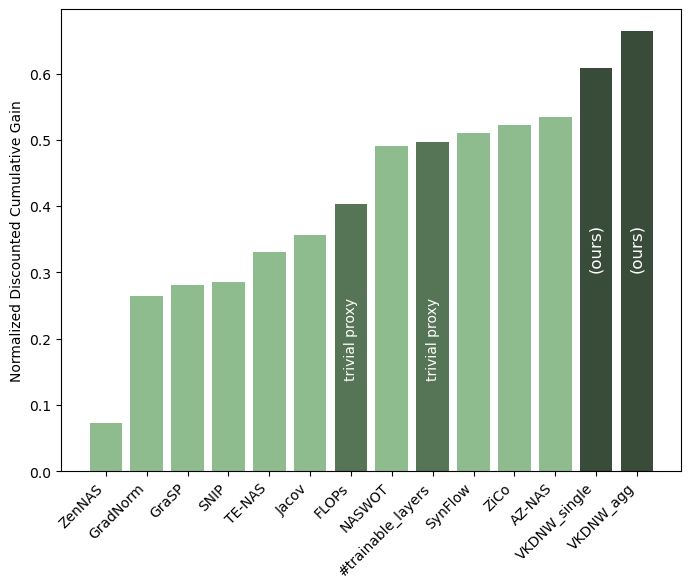

In [8]:
for plot_dataset in ['ImageNet16-120']:

    df_plot1 = table1_formatted[[f'ndcg1000_mean_{plot_dataset}']].astype(float)
    df_plot1 = df_plot1.loc[['vkdnw_comb', 'vkdnw_dim', 'flops', 'vkdnw', 'jacov', 'az_nas', 'zico', 'synflow', 'naswot', 'te_nas', 'snip', 'grasp', 'grad_norm', 'zen']].sort_values(f'ndcg1000_mean_{plot_dataset}')
    df_plot1 = df_plot1.reset_index()
    
    plt.figure(figsize=(8, 6))
    colors = ['#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#567556', '#8FBC8F', '#567556', '#8FBC8F', '#8FBC8F', '#8FBC8F', '#394B39', '#394B39']
    plt.bar(df_plot1['pred_name_'], df_plot1[f'ndcg1000_mean_{plot_dataset}'], color=colors)
    plt.ylabel('Normalized Discounted Cumulative Gain')
    
    plt.xticks(ticks=range(len(df_plot1['pred_name_'])), rotation=45, ha='right', labels=['ZenNAS', 'GradNorm', 'GraSP', 'SNIP', 'TE-NAS', 'Jacov', 'FLOPs', 'NASWOT', '#trainable_layers', 'SynFlow', 'ZiCo', 'AZ-NAS', 'VKDNW_single', 'VKDNW_agg'])
    #plt.text(14, 0.675, '(ours)', fontsize=12, ha='center', va='bottom', color='black')
    #plt.text(12, 0.6, '(ours)', fontsize=12, ha='center', va='bottom', color='black')
    
    plt.text(13, 0.3, '(ours)', fontsize=12, rotation=90, ha='center', va='bottom', color='white')
    plt.text(12, 0.3, '(ours)', fontsize=12, rotation=90, ha='center', va='bottom', color='white')
    
    plt.text(6, 0.2, "trivial proxy", rotation=90, va='center', ha='center', color='white')
    plt.text(8, 0.2, "trivial proxy", rotation=90, va='center', ha='center', color='white')
    plt.savefig(f'{plot_dataset}_filtered_figure1.eps', format='eps', bbox_inches='tight')
    plt.show()

In [31]:
"""
std = table1_formatted.loc[table1_formatted.index=='vkdnw_dim', f'ndcg1000_mean_{plot_dataset}'].astype(float).item()
plt.axhline(y=std, color='r', linestyle='--', linewidth=1.5, label='baseline')
plt.annotate('', 
             xy=(0, std+0.1), xycoords='data',  # Start position (category 2, y=10)
             xytext=(0, std), textcoords='data',  # End position (category 2, y=12)
             horizontalalignment='center',  # Centers the text horizontally
             arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='-|>', lw=1),
             fontsize=20, color='green')
    plt.text(2, std+0.05, 'Good rankings', fontsize=12, ha='center', va='bottom', color='green')
    plt.annotate('', 
             xy=(0, std-0.1), xycoords='data',  # Start position (category 1, y=10)
             xytext=(0, std), textcoords='data',  # End position (category 1, y=8)
             horizontalalignment='center',  # Centers the text horizontally
             arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='-|>', lw=1),
             fontsize=20, color='red')
    plt.text(2, std-0.05, 'Bad rankings', fontsize=12, ha='center', va='bottom', color='red')
"""

"\nstd = table1_formatted.loc[table1_formatted.index=='vkdnw_dim', f'ndcg1000_mean_{plot_dataset}'].astype(float).item()\nplt.axhline(y=std, color='r', linestyle='--', linewidth=1.5, label='baseline')\nplt.annotate('', \n             xy=(0, std+0.1), xycoords='data',  # Start position (category 2, y=10)\n             xytext=(0, std), textcoords='data',  # End position (category 2, y=12)\n             horizontalalignment='center',  # Centers the text horizontally\n             arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='-|>', lw=1),\n             fontsize=20, color='green')\n    plt.text(2, std+0.05, 'Good rankings', fontsize=12, ha='center', va='bottom', color='green')\n    plt.annotate('', \n             xy=(0, std-0.1), xycoords='data',  # Start position (category 1, y=10)\n             xytext=(0, std), textcoords='data',  # End position (category 1, y=8)\n             horizontalalignment='center',  # Centers the text horizontally\n             arrowprops=dict(f

# Ablation: add components

In [12]:
target = 'val_accs'
dataset = 'ImageNet16-120'
compute_graf = True
compute_graf_str = 'filtered' if compute_graf else 'unfiltered'
from nats_bench import create
from tss_utils import generate_accs
import os
import pandas as pd

In [13]:
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

if os.path.exists(f"./tss_features_{dataset}.pickle"):
    archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
else:
    archs = generate_accs(api_nats, dataset=dataset)
    print(f'No. of generated archs: {archs.shape[0]}')
    archs.to_pickle(f"./tss_features_{dataset}.pickle")

In [14]:
run_dict = { # NOTE: run from Nov 12th
    'cifar10': {
        'nazderaze/VKDNW/d4j99375': 1,
        'nazderaze/VKDNW/l45yucwc': 2,
        'nazderaze/VKDNW/l9ejiov9': 3,
        'nazderaze/VKDNW/24pmoya1': 4,
        'nazderaze/VKDNW/qvlu5obq': 5,
    },
    'cifar100': {
        'nazderaze/VKDNW/hobgq1ix': 1,
        'nazderaze/VKDNW/auky9zho': 2,
        'nazderaze/VKDNW/kcxfgdsv': 3,
        'nazderaze/VKDNW/0l87ned4': 4,
        'nazderaze/VKDNW/zviegsba': 5,
    },
    'ImageNet16-120': {
        'nazderaze/VKDNW/qi9tacm1': 1,
        'nazderaze/VKDNW/4d6ifp5c': 2,
        'nazderaze/VKDNW/kv4qea6e': 3,
        'nazderaze/VKDNW/ji88ojf6': 4,
        'nazderaze/VKDNW/0a21fd8a': 5,
    }
}

In [15]:
import wandb
import numpy as np
from sklearn.metrics import ndcg_score
api_wandb = wandb.Api()
from scipy.stats import kendalltau, spearmanr

log = None
for run_str, seed in run_dict[dataset].items():
    run = pd.DataFrame(api_wandb.run(run_str).scan_history())
    run.rename({'arch': 'net_str'}, axis=1, inplace=True)
    run = pd.merge(archs, run, on='net_str', how='inner')
    if compute_graf:
            run = run.loc[run['net'].notnull(), :]
        
    run['trainability'] = run['trainability'].astype(float)
    run['flops'] = run['flops'].astype(float)
    run['expressivity'] = run['expressivity'].astype(float)
    run['vkdnw_entropy'] = run['vkdnw_entropy'].astype(float)
    run['jacov'] = run['jacov'].astype(float)
    run.loc[run['jacov'].isnull(), 'jacov'] = run['jacov'].min()
    
    for flops in [True, False]:
        for expressivity in [True, False]:
            for trainability in [True, False]:
                for jacov in [True, False]:
                    for vkdnw in [True, False]:
                        run['score'] = 0
                        score_name = ''
                        if flops:
                            run['score'] += run['flops'].rank().apply(np.log)
                            score_name = score_name + 'flops_'
                        if expressivity:
                            run['score'] += run['expressivity'].rank().apply(np.log)
                            score_name = score_name + 'expressivity_'
                        if trainability:
                            run['score'] += run['trainability'].rank().apply(np.log)
                            score_name = score_name + 'trainability_'
                        if jacov:
                            run['score'] += run['jacov'].rank().apply(np.log)
                            score_name = score_name + 'jacov_'
                        if vkdnw:
                            run['score'] += run[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int).apply(np.log)
                            score_name = score_name + 'vkdnw_'
                        if flops or expressivity or trainability or jacov or vkdnw:
                            gain = ndcg_score(y_true=2**np.array([run[target].astype(float)])-1,
                                   y_score=np.array([run['score'].astype(float)]), k=1000)
                            kt = kendalltau(run[target].astype(float), run['score'].astype(float)).statistic
                            spr = spearmanr(run[target].astype(float), run['score'].astype(float)).statistic
                            if log is None:
                                log = pd.DataFrame({'pred_name': [score_name], 'gain': [gain], 'seed': [seed], 'kt': [kt], 'spr': [spr]})
                            else:
                                log = pd.concat([log, pd.DataFrame({'pred_name': [score_name], 'gain': [gain], 'seed': [seed], 'kt': [kt], 'spr': [spr]})], ignore_index=True)
log = log.groupby('pred_name').mean()
log = log.reset_index()
log['dataset'] = dataset

In [21]:
run['vkdnw_rank'] = run[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)
run[['vkdnw_rank', 'jacov', 'expressivity', 'trainability', 'flops']].corr(method='kendall')

,vkdnw_rank,jacov,expressivity,trainability,flops
vkdnw_rank,1.000000,0.561514,0.531758,0.235303,0.644348
jacov,0.561514,1.000000,0.623843,0.232650,0.396040
expressivity,0.531758,0.623843,1.000000,0.227954,0.492992
trainability,0.235303,0.232650,0.227954,1.000000,0.137490
flops,0.644348,0.396040,0.492992,0.137490,1.000000


In [16]:
log[['pred_name', 'kt', 'spr', 'gain']]

,pred_name,kt,spr,gain
0,expressivity_,0.497984,0.687395,0.050004
1,expressivity_jacov_,0.550468,0.738299,0.180333
2,expressivity_jacov_vkdnw_,0.650464,0.830108,0.417138
3,expressivity_trainability_,0.637707,0.837794,0.437631
4,expressivity_trainability_jacov_,0.664565,0.851587,0.431843
5,expressivity_trainability_jacov_vkdnw_,0.705093,0.880444,0.549705
6,expressivity_trainability_vkdnw_,0.703577,0.885626,0.545132
7,expressivity_vkdnw_,0.650108,0.835066,0.365797
8,flops_,0.517203,0.690739,0.386622
9,flops_expressivity_,0.599471,0.789414,0.271694


In [11]:
if dataset == 'ImageNet16-120':
    log_imagenet = log
if dataset == 'cifar100':
    log_cifar100 = log
if dataset == 'cifar10':
    log_cifar10 = log

In [18]:
log = pd.merge(log_cifar10[['pred_name', 'gain', 'dataset']], log_cifar100[['pred_name', 'gain', 'dataset']], on='pred_name', how='left', suffixes=('_C10', '_C100'))
log = pd.merge(log, log_imagenet[['pred_name', 'gain', 'dataset']], on='pred_name', how='left', suffixes=('', '_IN'))
log = log[['pred_name', 'gain_C10', 'gain_C100', 'gain']]
log = log.style.format(decimal=',', thousands='.', precision=3)

print(log.to_latex())

\begin{tabular}{llrrr}
 & pred_name & gain_C10 & gain_C100 & gain \\
0 & expressivity_ & 0,620 & 0,333 & 0,274 \\
1 & expressivity_jacov_ & 0,625 & 0,386 & 0,349 \\
2 & expressivity_jacov_vkdnw_ & 0,715 & 0,524 & 0,515 \\
3 & expressivity_trainability_ & 0,676 & 0,461 & 0,463 \\
4 & expressivity_trainability_jacov_ & 0,697 & 0,505 & 0,527 \\
5 & expressivity_trainability_jacov_vkdnw_ & 0,726 & 0,565 & 0,623 \\
6 & expressivity_trainability_vkdnw_ & 0,729 & 0,570 & 0,612 \\
7 & expressivity_vkdnw_ & 0,725 & 0,512 & 0,489 \\
8 & flops_ & 0,743 & 0,576 & 0,403 \\
9 & flops_expressivity_ & 0,739 & 0,522 & 0,434 \\
10 & flops_expressivity_jacov_ & 0,746 & 0,543 & 0,484 \\
11 & flops_expressivity_jacov_vkdnw_ & 0,773 & 0,593 & 0,553 \\
12 & flops_expressivity_trainability_ & 0,781 & 0,610 & 0,630 \\
13 & flops_expressivity_trainability_jacov_ & 0,780 & 0,617 & 0,646 \\
14 & flops_expressivity_trainability_jacov_vkdnw_ & 0,785 & 0,636 & 0,664 \\
15 & flops_expressivity_trainability_vkdnw_ & 0

In [19]:
log

,pred_name,gain_C10,gain_C100,gain
0,expressivity_,"0,620","0,333","0,274"
1,expressivity_jacov_,"0,625","0,386","0,349"
2,expressivity_jacov_vkdnw_,"0,715","0,524","0,515"
3,expressivity_trainability_,"0,676","0,461","0,463"
4,expressivity_trainability_jacov_,"0,697","0,505","0,527"
5,expressivity_trainability_jacov_vkdnw_,"0,726","0,565","0,623"
6,expressivity_trainability_vkdnw_,"0,729","0,570","0,612"
7,expressivity_vkdnw_,"0,725","0,512","0,489"
8,flops_,"0,743","0,576","0,403"
9,flops_expressivity_,"0,739","0,522","0,434"


# Ablation: number of params

In [21]:
run_dict = {
    'cifar10': {
        'nazderaze/VKDNW/qidn2otn': 8,
        'nazderaze/VKDNW/6hjqb5bg': 16,
        'nazderaze/VKDNW/aeorb1n4': 32,
        'nazderaze/VKDNW/814p8cta': 64,
        'nazderaze/VKDNW/b7fqkpja': 128,
        'nazderaze/VKDNW/a3trfe5b': 256,
        
    },
    'cifar100': {
        'nazderaze/VKDNW/e41paut9': 8,
        'nazderaze/VKDNW/x4rxdfln': 16,
        'nazderaze/VKDNW/kqcbt46h': 32,
        'nazderaze/VKDNW/athv602z': 64,
        'nazderaze/VKDNW/h4l3ix1f': 128,
        'nazderaze/VKDNW/c4wdz8j1': 256,
    },
    'ImageNet16-120': { # WARNING: computed with batch size 32
        'nazderaze/VKDNW/3cq8s146': 8,
        'nazderaze/VKDNW/z8uaqk2a': 16,
        'nazderaze/VKDNW/roa39dl1': 32,
        'nazderaze/VKDNW/lvyxai7o': 64,
        'nazderaze/VKDNW/8zlcyyab': 128,
        'nazderaze/VKDNW/u6rkf2c1': 256,
    }
}

In [22]:
target = 'val_accs'
compute_graf = True
compute_graf_str = 'filtered' if compute_graf else 'unfiltered'
from nats_bench import create
from tss_utils import generate_accs
import os
import pandas as pd

In [23]:
import wandb
import numpy as np
from sklearn.metrics import ndcg_score
api_wandb = wandb.Api()
from scipy.stats import kendalltau, spearmanr
log = None
for dataset in ['cifar10', 'cifar100', 'ImageNet16-120']:
    api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

    if os.path.exists(f"./tss_features_{dataset}.pickle"):
        archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
    else:
        archs = generate_accs(api_nats, dataset=dataset)
        print(f'No. of generated archs: {archs.shape[0]}')
        archs.to_pickle(f"./tss_features_{dataset}.pickle")
    for run_str, params_grad_len in run_dict[dataset].items():
        run = pd.DataFrame(api_wandb.run(run_str).scan_history())
        run.rename({'arch': 'net_str'}, axis=1, inplace=True)
        run = pd.merge(archs, run, on='net_str', how='inner')
        if compute_graf:
            run = run.loc[run['net'].notnull(), :]
            
        run['vkdnw_entropy'] = run['vkdnw_entropy'].astype(float)
        run['vkdnw'] = run[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)
        kt = kendalltau(run[target], run['vkdnw']).statistic
        spr = spearmanr(run[target], run['vkdnw']).statistic
        gain1000 = ndcg_score(y_true=2**np.array([run[target]])-1, y_score=np.array([run['vkdnw']]), k=1000)
        if log is None:
            log = pd.DataFrame({'params_grad_len': params_grad_len, 'kendall': kt, 'spearman': spr, 'gain1000': gain1000, 'dataset': dataset}, index=[0])
        else:
            log = pd.concat([log, pd.DataFrame({'params_grad_len': params_grad_len, 'kendall': kt, 'spearman': spr, 'gain1000': gain1000, 'dataset': dataset}, index=[0])])

/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)
/home/tyblondr/

In [32]:
log

,params_grad_len,kendall,spearman,gain1000,dataset
0,8,0.578725,0.772969,0.713467,cifar10
0,16,0.616284,0.811585,0.727734,cifar10
0,32,0.621043,0.817272,0.736949,cifar10
0,64,0.623583,0.819374,0.743639,cifar10
0,128,0.617675,0.814156,0.748671,cifar10
0,256,0.617148,0.813881,0.755885,cifar10
0,8,0.593131,0.787760,0.556043,cifar100
0,16,0.635182,0.828213,0.581007,cifar100
0,32,0.637846,0.831997,0.592725,cifar100
0,64,0.638649,0.833122,0.609926,cifar100


# Ablation: batch size

In [24]:
dataset = 'ImageNet16-120'
run_dict = {
    'random': {
        'nazderaze/VKDNW/xqqaw6yc': 8,
        'nazderaze/VKDNW/4ab3232v': 16,
        'nazderaze/VKDNW/7g8ypth8': 32,
        'nazderaze/VKDNW/kt4a03ae': 64,
        'nazderaze/VKDNW/mkunsyr8': 128,
    },
    'real': {
        'nazderaze/VKDNW/an8hnrw4': 8,
        'nazderaze/VKDNW/wk68ked0': 16,
        'nazderaze/VKDNW/omf8ubpa': 32,
        'nazderaze/VKDNW/cyeozs30': 64,
        'nazderaze/VKDNW/9c67f9if': 128,
    },
}

In [25]:
target = 'val_accs'
compute_graf = True
compute_graf_str = 'filtered' if compute_graf else 'unfiltered'
from nats_bench import create
from tss_utils import generate_accs
import os
import pandas as pd

In [26]:
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

if os.path.exists(f"./tss_features_{dataset}.pickle"):
    archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
else:
    archs = generate_accs(api_nats, dataset=dataset)
    print(f'No. of generated archs: {archs.shape[0]}')
    archs.to_pickle(f"./tss_features_{dataset}.pickle")

In [27]:
import wandb
import numpy as np
from sklearn.metrics import ndcg_score
api_wandb = wandb.Api()
from scipy.stats import kendalltau, spearmanr
log = None
for input_type in ['random', 'real']:
    for run_str, batch_size in run_dict[input_type].items():
        run = pd.DataFrame(api_wandb.run(run_str).scan_history())
        run.rename({'arch': 'net_str'}, axis=1, inplace=True)
        run = pd.merge(archs, run, on='net_str', how='inner')
        if compute_graf:
            run = run.loc[run['net'].notnull(), :]
            
        run['vkdnw_entropy'] = run['vkdnw_entropy'].astype(float)
        run['vkdnw'] = run[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)
        kt = kendalltau(run[target], run['vkdnw']).statistic
        spr = spearmanr(run[target], run['vkdnw']).statistic
        gain1000 = ndcg_score(y_true=2**np.array([run[target]])-1, y_score=np.array([run['vkdnw']]), k=1000)
        if log is None:
            log = pd.DataFrame({'input_type': input_type, 'batch_size': batch_size, 'kendall': kt, 'spearman': spr, 'gain1000': gain1000, 'dataset': dataset}, index=[0])
        else:
            log = pd.concat([log, pd.DataFrame({'input_type': input_type, 'batch_size': batch_size, 'kendall': kt, 'spearman': spr, 'gain1000': gain1000, 'dataset': dataset}, index=[0])])

In [28]:
log

,input_type,batch_size,kendall,spearman,gain1000,dataset
0,random,8,0.615491,0.808344,0.617000,ImageNet16-120
0,random,16,0.614253,0.808054,0.603795,ImageNet16-120
0,random,32,0.619208,0.812353,0.611849,ImageNet16-120
0,random,64,0.621424,0.813849,0.617492,ImageNet16-120
0,random,128,0.621456,0.813670,0.615802,ImageNet16-120
0,real,8,0.613570,0.805492,0.599226,ImageNet16-120
0,real,16,0.607511,0.800261,0.595315,ImageNet16-120
0,real,32,0.611776,0.804410,0.593846,ImageNet16-120
0,real,64,0.614071,0.806107,0.595332,ImageNet16-120
0,real,128,0.614566,0.806407,0.590693,ImageNet16-120


# Ablation: parameter choice
 - (which parameter from given layer is used for FIM computation)

In [5]:
import pandas as pd
import wandb
import numpy as np
from sklearn.metrics import ndcg_score
api_wandb = wandb.Api()
from scipy.stats import kendalltau, spearmanr
from nats_bench import create
from tss_utils import generate_accs
import os

dataset = 'ImageNet16-120'
run_dict = {
    'nazderaze/VKDNW/qouljd1x': -1,
    'nazderaze/VKDNW/7oxh7yh0': 1,
    'nazderaze/VKDNW/rrpcmc5x': 0.8,
    'nazderaze/VKDNW/4yt3p2ng': 0.6,
    'nazderaze/VKDNW/6khv3yvf': 0.4,
    'nazderaze/VKDNW/cnm06lcv': 0.2,
    'nazderaze/VKDNW/3e44usbh': 0
}

In [6]:
target = 'val_accs'
compute_graf = True
compute_graf_str = 'filtered' if compute_graf else 'unfiltered'

In [7]:
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

if os.path.exists(f"./tss_features_{dataset}.pickle"):
    archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
else:
    archs = generate_accs(api_nats, dataset=dataset)
    print(f'No. of generated archs: {archs.shape[0]}')
    archs.to_pickle(f"./tss_features_{dataset}.pickle")

In [13]:
log = None
for run_str, p in run_dict.items():
    run = pd.DataFrame(api_wandb.run(run_str).scan_history())
    run.rename({'arch': 'net_str'}, axis=1, inplace=True)
    run = pd.merge(archs, run, on='net_str', how='inner')
    if compute_graf:
        run = run.loc[run['net'].notnull(), :]
        
    run['vkdnw_entropy'] = run['vkdnw_entropy'].astype(float)
    run['expressivity'] = run['expressivity'].astype(float)
    run['trainability'] = run['trainability'].astype(float)
    run['jacov'] = run['jacov'].astype(float)
    run.loc[run['jacov'].isnull(), 'jacov'] = run['jacov'].min()
    run['vkdnw'] = run[['vkdnw_dim', 'vkdnw_entropy']].apply(tuple, axis=1).rank(method='dense', ascending=True).astype(int)
    run['vkdnw_comb_rank'] = run['vkdnw'].rank().apply(np.log) + run[
                'expressivity'].rank().apply(np.log) + run['trainability'].rank().apply(np.log) + run[
                                                         'flops'].rank().apply(np.log) + run['jacov'].rank().apply(np.log)
    kt = kendalltau(run[target], run['vkdnw']).statistic
    spr = spearmanr(run[target], run['vkdnw']).statistic
    gain1000 = ndcg_score(y_true=2**np.array([run[target]])-1, y_score=np.array([run['vkdnw']]), k=1000)
    if log is None:
        log = pd.DataFrame({'p': p, 'kendall': kt, 'spearman': spr, 'gain1000': gain1000, 'dataset': dataset}, index=[0])
    else:
        log = pd.concat([log, pd.DataFrame({'p': p, 'kendall': kt, 'spearman': spr, 'gain1000': gain1000, 'dataset': dataset}, index=[0])])

In [14]:
log

,p,kendall,spearman,gain1000,dataset
0,-1.0,0.617591,0.810602,0.585697,ImageNet16-120
0,1.0,0.620994,0.813487,0.594990,ImageNet16-120
0,0.8,0.622468,0.814124,0.608535,ImageNet16-120
0,0.6,0.622533,0.814194,0.598097,ImageNet16-120
0,0.4,0.625056,0.816915,0.605710,ImageNet16-120
0,0.2,0.622207,0.814563,0.601877,ImageNet16-120
0,0.0,0.621685,0.813899,0.614836,ImageNet16-120


# Create features for all networks

In [1]:
import pandas as pd
data = pd.read_csv('../../GRAF/zc_combine/data/nb201_features.csv')

In [55]:
def tostr(net):
    
    op_dict = {
        '0': '|skip_connect~',
        '1': '|none~',
        '2': '|nor_conv_3x3~',
        '3': '|nor_conv_1x1~',
        '4': '|avg_pool_3x3~',
    }

    op_ids = net.split(', ')
    op_ids[0] = op_ids[0].split('(')[1]
    op_ids[-1] = op_ids[-1].split(')')[0]
    
    return op_dict[op_ids[0]]+'0|+'+op_dict[op_ids[1]]+'0'+op_dict[op_ids[3]]+'1|+'+op_dict[op_ids[2]]+'0'+op_dict[op_ids[4]]+'1'+op_dict[op_ids[5]]+'2|'

# Test
data['net_str_test'] = data['net'].apply(tostr)
print(sum((data['net_str']!=data['net_str_test']).astype(int)))

0


In [72]:
data_all = pd.read_csv('../../GRAF/zc_combine/data/nb201_features_all.csv')
data_all['net_str'] = data_all['Unnamed: 0'].apply(tostr)
data_all = data_all.drop('Unnamed: 0', axis=1)
data_all.to_csv('../../GRAF/zc_combine/data/nb201_features_all.csv')

AttributeError: 'int' object has no attribute 'split'

# Supplementary: vkdnw and number of parameters correlation

/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/tyblondr/.conda/envs/VKDNW/lib/python3.8/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


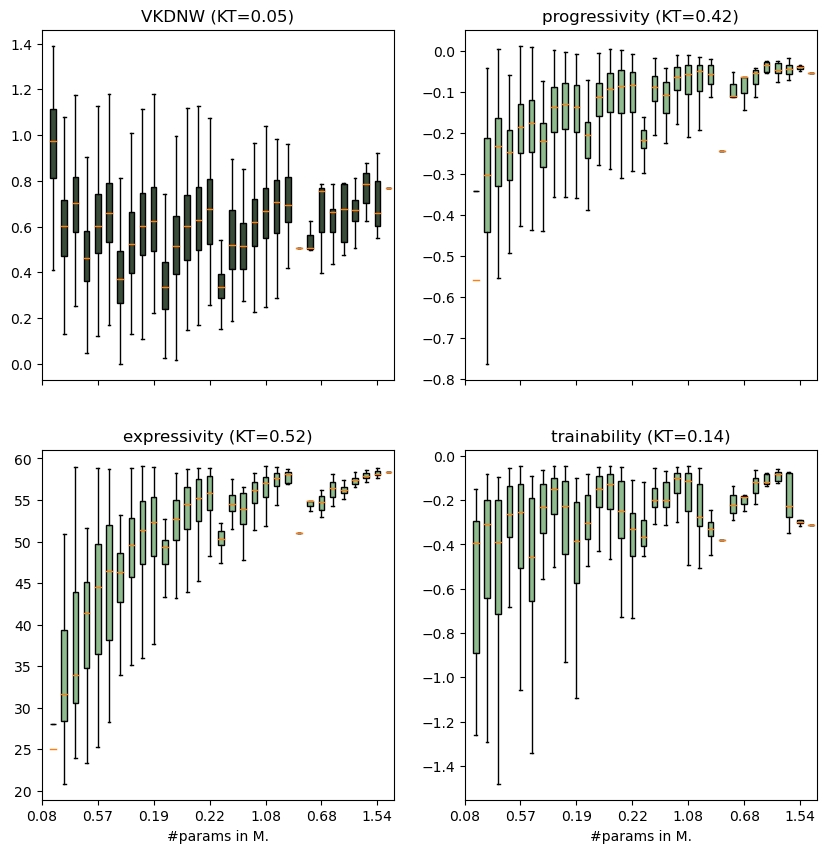

In [24]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
api_wandb = wandb.Api()
run = pd.DataFrame(api_wandb.run('nazderaze/VKDNW/ss2kwvpp').scan_history())
from scipy.stats import kendalltau
from nats_bench import create
from tss_utils import generate_accs
import os
dataset = 'ImageNet16-120'
compute_graf = True

api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)

if os.path.exists(f"./tss_features_{dataset}.pickle"):
    archs = pd.read_pickle(f"./tss_features_{dataset}.pickle")
else:
    archs = generate_accs(api_nats, dataset=dataset)
    print(f'No. of generated archs: {archs.shape[0]}')
    archs.to_pickle(f"./tss_features_{dataset}.pickle")


run.rename({'arch': 'net_str'}, axis=1, inplace=True)
run = pd.merge(archs, run, on='net_str', how='inner')
if compute_graf:
    run = run.loc[run['net'].notnull(), :]
    
def adjust_xticks(ax, labels, step=5):
    ticks_to_show = range(len(labels))[::step]  # Select every 5th tick
    formatted_labels = [f"{float(labels[i]):.2f}" for i in ticks_to_show]  # Format to two decimals
    ax.set_xticks(ticks_to_show)
    ax.set_xticklabels(formatted_labels)

run['trainability'] = run['trainability'].astype(float)
run['progressivity'] = run['progressivity'].astype(float)
run['expressivity'] = run['expressivity'].astype(float)
run['vkdnw_entropy'] = run['vkdnw_entropy'].astype(float)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex=True)

pred = 'vkdnw_entropy'
data_to_plot = [run[pred][run['params'] == cat] for cat in run['params'].unique()]
kt = kendalltau(run['params'], run[pred]).statistic
bplot = axs[0, 0].boxplot(data_to_plot, labels=run['params'].unique(), showfliers=False, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor('#394B39')
axs[0, 0].set_title(f"VKDNW (KT={kt:.2f})")

pred = 'progressivity' 
data_to_plot = [run[pred][run['params'] == cat] for cat in run['params'].unique()]
kt = kendalltau(run['params'], run[pred]).statistic
bplot = axs[0, 1].boxplot(data_to_plot, labels=run['params'].unique(), showfliers=False, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor('#8FBC8F')
axs[0, 1].set_title(f"{pred} (KT={kt:.2f})")

pred = 'expressivity'
data_to_plot = [run[pred][run['params'] == cat] for cat in run['params'].unique()]
kt = kendalltau(run['params'], run[pred]).statistic
bplot = axs[1, 0].boxplot(data_to_plot, labels=run['params'].unique(), showfliers=False, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor('#8FBC8F')
adjust_xticks(axs[1, 0], run['params'].unique())
axs[1, 0].set_title(f"{pred} (KT={kt:.2f})")
axs[1, 0].set_xlabel('#params in M.')


pred = 'trainability'
data_to_plot = [run[pred][run['params'] == cat] for cat in run['params'].unique()]
kt = kendalltau(run['params'], run[pred]).statistic
bplot = axs[1, 1].boxplot(data_to_plot, labels=run['params'].unique(), showfliers=False, patch_artist=True)
for patch in bplot['boxes']:
    patch.set_facecolor('#8FBC8F')
adjust_xticks(axs[1, 1], run['params'].unique())
axs[1, 1].set_title(f"{pred} (KT={kt:.2f})")
axs[1, 1].set_xlabel('#params in M.')

plt.savefig(f'ImageNet16-120_filtered_num_params_not_dim_boxplot_vkdnw.eps', format='eps')
plt.show()